In [492]:
import os
import pickle

#Import Data 
path = './data/split_data/'
directory = os.listdir(path)
for file in directory:
    if file.endswith(".pickle"):
        with open(path+file, 'rb') as f:
            placeholder = file.split('.')[0] #Placeholder to modify file name to variable name
            vars()[placeholder] = pickle.load(f)
            print('Loaded', file)

Loaded X_resampled_down.pickle
Loaded X_resampled_up.pickle
Loaded X_smoted.pickle
Loaded X_train_down.pickle
Loaded X_train_up.pickle
Loaded y_resampled_down.pickle
Loaded y_resampled_up.pickle
Loaded y_smoted.pickle
Loaded y_train_down.pickle
Loaded y_train_up.pickle


In [ ]:
#Working Copy Figure out how to fit into workbook
# #Import Data From Director and Assign File Name to Variable Name
# def import_data(directory_path, file_extension =".pickle"):
#     data_list = []
#     directory = os.listdir(path)
#     for file in directory:
#         if file.endswith(file_extension):
#             with open(path+file, 'rb') as f:
#                 placeholder = file.split('.')[0] #Placeholder to modify file name to variable name
#                 vars()[placeholder] = pickle.load(f)
#                 data_list.append(vars()[placeholder])
#                 print('Loaded', file)
#     return data_list

# path = './data/split_data/'
# split_data = import_data(path, file_extension =".pickle")

In [493]:
list_data = [X_smoted,y_smoted,X_train_down,y_train_down, \
             X_train_up,y_train_up, X_resampled_down,y_resampled_down,X_resampled_up,\
             y_resampled_up]

In [500]:
#Import required pacakages
#Imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

#Matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

#Numpy
import numpy as np

#Pandas
import pandas as pd
import pandas_profiling

#Seaborn
import seaborn as sns
sns.set()

#Sklearn
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import median_absolute_error
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix)

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier, #For each feature split rule is random, not optimal
                              VotingClassifier, 
                              AdaBoostClassifier, 
                              BaggingRegressor)

from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     learning_curve,
                                     validation_curve,
                                     train_test_split,
                                     cross_validate)
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
#XGBoost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

The methodology that I’ll follow when building the classifiers goes as follows:

Build a pipeline that handles all the steps when fitting the classifier using scikit-learn’s `make_pipeline` which will have two steps:

I. Standardizing the data to speed up convergence and make all features on the same scale.

II. The classifier (estimator) we want to use to fit the model.

2. Use GridSearchCV to tune hyperparameters using 10-folds cross validation. We can use RandomizedSearchCV which is faster and may outperform GridSearchCV especially if we have more than two hyperparameters and the range for each one is very big; however, GridSearchCV will work just fine since we have only two hyperparameters and descent range.

3. Fit the model using training data.

4. Plot both confusion matrix and ROC curve for the best estimator using test data.

Repeat the above steps for `Random Forest`, `Gradient Boosting Trees`, `K-Nearest Neighbors`, `Logistic Regression` and `Support Vector Machine`. Next, pick the classifier that has the highest cross validation f1 score.

# Model 1 - Random Forest
First, fit a random forest classifier using `unsampled`, `upsampled`, and `downsampled` data. Second, evaluate each method using cross validation CV f1-score and pick the one with the highest CV F1 score. The best method will be used to fit the rest of the classifiers

Hyperparameters to tune:

`max_features`: How many features to consider randomly on each split to help avoid having few strong features to be picked on each split and let other features have the chance to contribute. The predictions will be less correlated and the variance of each tree will decrease.

`min_samples_leaf`: How many examples to have for each split to be a final leaf node.

In [28]:
'''
Decision Trees are prone to high variance. Comes at cost of overfitting the training set.

Huristic: Greedy Search
Informatino Entropy
Split wiht entrop minimization rule
Boostrap Aggregating - Sample with Replacement

Ensemble Methods Random Forests
Introduce randomness when building each tree.
For a split, do not take the “best” feature split.
First, randomly choose sqrt(n_feat) features.
Only choose the best split among these.

Bagging - Reduces Bagging
-Average Voting
-Max Voting
looking at bootstrapped samples and running several different models on the data allows the classifier to 
find the best aggregate model that will generalize best to our data.

'''

'\nDecision Trees are prone to high variance. Comes at cost of overfitting the training set.\n\nHuristic: Greedy Search\nInformatino Entropy\nSplit wiht entrop minimization rule\nBoostrap Aggregating - Sample with Replacement\n\nEnsemble Methods Random Forests\nIntroduce randomness when building each tree.\nFor a split, do not take the “best” feature split.\nFirst, randomly choose sqrt(n_feat) features.\nOnly choose the best split among these.\n\nBagging - Reduces Bagging\n-Average Voting\n-Max Voting\nlooking at bootstrapped samples and running several different models on the data allows the classifier to \nfind the best aggregate model that will generalize best to our data.\n\n'

In [495]:
def bias_metric(y_true, y_pred):
    return np.mean((np.mean(y_pred) - y_true)**2)

def variance_metric(y_true, y_pred):
    return np.var(y_true - y_pred)

In [496]:
i=0

placeholder_variance=[]
placeholder_bias=[]

variance = []
bias = []
test_range = np.arange(1, 100, 1) #Number of Trees

while i < len(list_data)-1:
    X=list_data[i]
    y=list_data[i+1]
    for r in test_range:
        cv_out = cross_validate(
            estimator=BaggingRegressor(
                DecisionTreeRegressor(random_state=123), n_estimators=r),
            X=X,
            y=y,
            cv=3,
            return_train_score=True,
            scoring={
                "variance": make_scorer(variance_metric),
                "bias": make_scorer(bias_metric)
            },
            n_jobs=-1,
        )
        placeholder_variance.append(np.mean(cv_out['test_variance']))
        placeholder_bias.append(np.mean(cv_out['test_bias']))
        
    variance.append(placeholder_variance)
    bias.append(placeholder_bias)
    placeholder_variance=[] #clear placeholder
    placeholder_bias=[] #clear placeholder
    i+=2

TypeError: 'str' object is not callable

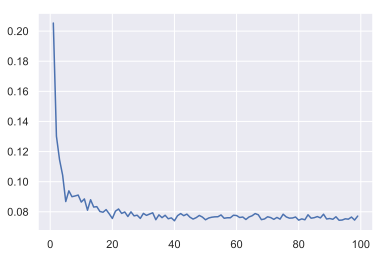

In [502]:
titles = ['Smoted','Train Down','Train Up', 'Resampled Down', 'Resampled Up']
for i in range(len(variance)):
    plt.figure(dpi=150)
    plt.plot(test_range, variance[i], label='variance')
    #plt.ylim((0, 0.65))
    plt.xlabel('Number of Estimators')
    plt.ylabel('Variance Score');
    plt.title('Variance Score vs No. of Estimators - ' +titles[i]);

    plt.figure(dpi=150)
    plt.plot(test_range, bias[i], label='bias', c='r')
    #plt.ylim((0, 0.25))
    plt.xlabel('Number of Estimators')
    plt.ylabel('Bias Score');
    plt.title('Bias Score vs No. of Estimators - ' +titles[i]);

In [503]:
# Build random forest classifier
def random_forest_classifier(X_train, y_train):
    methods_data = {"Original": (X_train, y_train),
                    "SMOTE": (X_smoted, y_smoted),
                    "Upsampled": (X_train_up, y_train_up),
                    "Downsampled": (X_train_down, y_train_down)}

    for method in methods_data.keys():
        pip_rf = make_pipeline(StandardScaler(),
                               RandomForestClassifier(n_estimators=500, #Typically Sufficient
                                                      class_weight="balanced",
                                                      random_state=123))

        hyperparam_grid = {
            "randomforestclassifier__n_estimators": [10, 50, 100, 200, 500],
            "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5], #sqrt/log2 => max_features = sqrt/log2(n_features), 
            "randomforestclassifier__min_samples_leaf": [1, 3, 5, 10, 20, 30],
            "randomforestclassifier__criterion": ["gini", "entropy"]}

        gs_rf = GridSearchCV(pip_rf,
                             hyperparam_grid,
                             scoring="precision", #The F1 score can be interpreted as a weighted average of the precision and recall, 
                             #where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of 
                             #precision and recall to the F1 score are equal. The formula for the F1 score is:
                             cv=10, # Number of K-fold cross validation
                             n_jobs=-1) # Setting n_jobs to -1, specifys that all CPUs are used

        gs_rf.fit(methods_data[method][0], methods_data[method][1])

        print(f"\033[1m\033[0mThe best hyperparameters for {method} data:")
        for hyperparam in gs_rf.best_params_.keys():
            print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])

        print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_rf.best_score_ * 100:.2f}%.")

In [504]:
print('SMOTE')
X=list_data[0]
y=list_data[1]
random_forest_classifier(X, y)

SMOTE
The best hyperparameters for Original data:
criterion :  entropy
max_features :  log2
min_samples_leaf :  3
n_estimators :  200
Best 10-folds CV f1-score: 97.98%.


KeyboardInterrupt: 

In [112]:
i=0
import math
while i < len(list_data[0:2])-1:
    print(titles[math.floor(i/2)])
    X=list_data[i]
    y=list_data[i+1]
    random_forest_classifier(X, y)
    i+=2

SMOTE
The best hyperparameters for Original data:
criterion :  entropy
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 90.29%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.
ADASYN


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Original data:
criterion :  entropy
max_features :  log2
min_samples_leaf :  1
n_estimators :  200
Best 10-folds CV f1-score: 88.35%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.
Train Down


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Original data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.
Train Up
The best hyperparameters for Original data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.
Resampled Down


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Original data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  5
n_estimators :  50
Best 10-folds CV f1-score: 72.21%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.
Resampled Up
The best hyperparameters for Original data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 99.01%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.80%.
The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 73.37%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Hyperparameters as discovered by RandomForestClassifiera with Best 10-fold CV F1-Score of 98.80%:

- criterion :  gini
- max_features :  log2
- min_samples_leaf :  1
- n_estimators :  100
- Best 10-folds CV f1-score: 98.80%.

The upsampled data will be used to fit the rest of the classifiers.

In [135]:
def Random_Forest_Classifier(X_train, y_train,n_estimators,criterion,max_features,min_samples_leaf):
    # Reassign original training data to upsampled data
    X_train_re, y_train_re = np.copy(X_train), np.copy(y_train)

    # Refit RF classifier using best params
    clf_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=n_estimators,
                                                  criterion=criterion,
                                                  max_features=max_features,
                                                  min_samples_leaf=min_samples_leaf,
                                                  class_weight="balanced",
                                                  n_jobs=-1,
                                                  random_state=123))
    clf_rf.fit(X_train_re, y_train_re)
        
    return clf_rf

# Check Balance of Classes
- Look at proportion of classes to see if we're dealing with balanced or imbalanced data, since each one has its own set of tools to be used when fitting classifiers

# Get number of Yes/No Attritions

In [190]:
#Import validation and test data
path = './data/split_data/val_test/'
directory = os.listdir(path)
for file in directory:
    if file.endswith(".pickle"):
        with open(path+file, 'rb') as f:
            placeholder = file.split('.')[0] #Placeholder to modify file name to variable name
            vars()[placeholder] = pickle.load(f)
            print('Loaded', file)

Loaded X_test.pickle
Loaded X_val.pickle
Loaded X_val_copy.pickle
Loaded y_test.pickle
Loaded y_val.pickle


In [193]:
val_data_list = [X_val,y_val]
test_data_list = [X_test,y_test]

In [267]:
n_estimators = 100
criterion = 'gini'
max_features = 'log2'
min_samples_leaf = 1

new_list_data_per_tunining = [X_smoted,y_smoted,X_adasyn,y_adasyn,X_train_up,y_train_up,X_resampled_up,y_resampled_up]
titles = ['SMOTE','ADASYN','TrainUp','ResampledUp']
i=0
while i < len(new_list_data_per_tunining)-1:
    X=new_list_data_per_tunining[i]
    y=new_list_data_per_tunining[i+1]
    clf_RandomForest = Random_Forest_Classifier(X, y, n_estimators,criterion,max_features,min_samples_leaf)
    #Save Model
    filename = './data/fit_models/'+titles[math.floor(i/2)]+'.sav'
    pickle.dump(clf_RandomForest, open(filename, 'wb'))
    
    #Predict Y using Fitted Models 
    y_pred = clf_RandomForest.predict(val_data_list[0])
    filename = './data/fit_models/y_pred/ypred_'+titles[math.floor(i/2)]+'.sav'
    pickle.dump(y_pred, open(filename, 'wb'))
    i+=2
print('Fitting Models Completed')

Fitting Models Completed


In [268]:
#Import y_pred
path = './data/fit_models/y_pred/'
directory = os.listdir(path)
y_pred_list= []
for file in directory:
    if file.endswith(".sav"):
        with open(path+file, 'rb') as f:
            placeholder = file.split('.')[0] #Placeholder to modify file name to variable name
            vars()[placeholder] = pickle.load(f)
            y_pred_list.append(vars()[placeholder])
            print('Loaded', file)

Loaded ypred_ADASYN.sav
Loaded ypred_ResampledUp.sav
Loaded ypred_SMOTE.sav
Loaded ypred_TrainUp.sav


# Check Balance of Classes
- Look at proportion of classes to see if we're dealing with balanced or imbalanced data, since each one has its own set of tools to be used when fitting classifiers

# Get number of Yes/No Attritions

Let’s refit the Random Forest with Upsampled data using best hyperparameters tuned above and plot confusion matrix and ROC curve using test data.

In [489]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.figure(dpi=600)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_title(title)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=20)
    fig.tight_layout()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    ax.grid(None)
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.xaxis.set_label_coords(0.5,-0.15)
    return ax

Confusion matrix, without normalization
Random Forest Classifcation Report: 
                precision    recall  f1-score   support

           0       0.91      0.98      0.94       246
           1       0.85      0.48      0.61        48

   micro avg       0.90      0.90      0.90       294
   macro avg       0.88      0.73      0.78       294
weighted avg       0.90      0.90      0.89       294



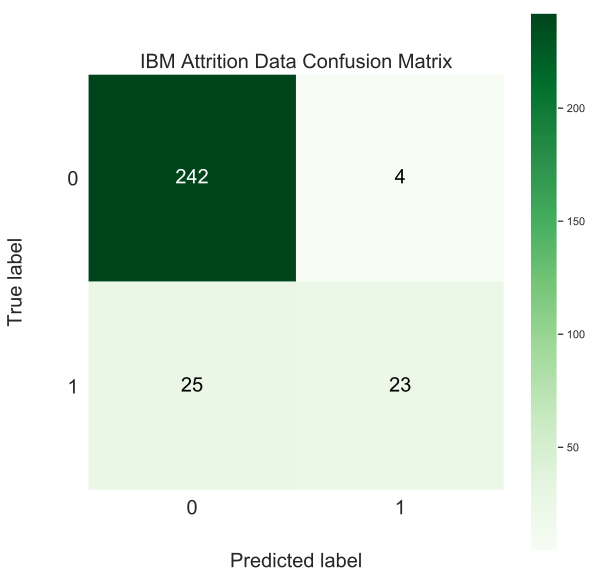

In [490]:
#Print Confusion Matrix
cm_gb = plot_confusion_matrix(y_val, y_pred, title='IBM Attrition Data Confusion Matrix');
print('Random Forest Classifcation Report: \n ', classification_report(y_val,y_pred));

Confusion matrix, without normalization
Classifcation Report for: 
SMOTE               precision    recall  f1-score   support

           0       0.88      0.99      0.93       246
           1       0.82      0.29      0.43        48

   micro avg       0.87      0.87      0.87       294
   macro avg       0.85      0.64      0.68       294
weighted avg       0.87      0.87      0.85       294

Confusion matrix, without normalization
Classifcation Report for: 
ADASYN               precision    recall  f1-score   support

           0       0.87      0.98      0.92       246
           1       0.69      0.23      0.34        48

   micro avg       0.86      0.86      0.86       294
   macro avg       0.78      0.60      0.63       294
weighted avg       0.84      0.86      0.83       294

Confusion matrix, without normalization
Classifcation Report for: 
TrainUp               precision    recall  f1-score   support

           0       0.88      0.99      0.93       246
           1   

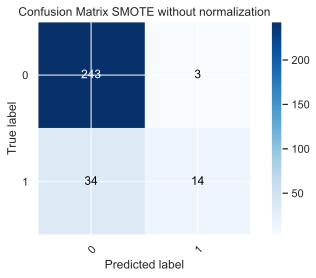

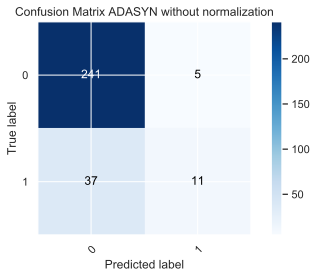

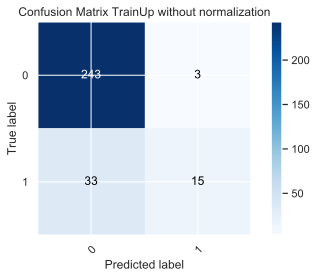

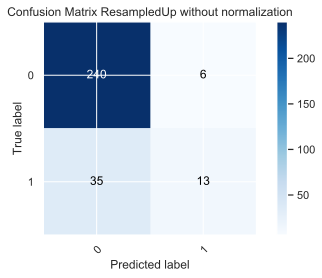

In [270]:
# Plot non-normalized confusion matrix
titles = ['SMOTE','ADASYN','TrainUp','ResampledUp']
for idx, y_pred in enumerate(y_pred_list):
    cm = plot_confusion_matrix(y_val, y_pred, title='Confusion Matrix '+titles[idx]+' without normalization');
    print('Classifcation Report for: \n'+titles[idx], classification_report(y_val,y_pred));

In [271]:
path = './data/fit_models/'
directory = os.listdir(path)
y_pred_list= []
for file in directory:
    if file.endswith(".sav"):
        with open(path+file, 'rb') as f:
            placeholder = file.split('.')[0] #Placeholder to modify file name to variable name
            vars()[placeholder] = pickle.load(f)
            y_pred_list.append(vars()[placeholder])
            print('Loaded', file)

Loaded ADASYN.sav
Loaded ResampledUp.sav
Loaded SMOTE.sav
Loaded TrainUp.sav


In [272]:
fitted_models = [SMOTE,ADASYN,TrainUp,ResampledUp]

Random Forest SMOTE ROC AUC score =  0.8241869918699187
Random Forest ADASYN ROC AUC score =  0.8148712737127372
Random Forest TrainUp ROC AUC score =  0.8334603658536585
Random Forest ResampledUp ROC AUC score =  0.8246104336043361


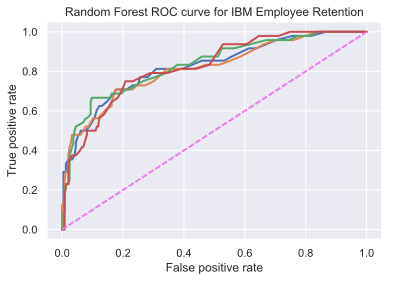

In [273]:
titles = ['SMOTE','ADASYN','TrainUp','ResampledUp']
for idx, model in enumerate(fitted_models):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Random Forest ROC curve for IBM Employee Retention');
    print("Random Forest "+titles[idx]+" ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

# *NOTE* PAST THIS POINT NOTHING IS AUTOMATED

# Gradient Boosting Trees

Gradient Boosting trees are the same as Random Forest except for:

It starts with small tree and start learning from grown trees by taking into account the residual of grown trees.
More trees can lead to overfitting; opposite to Random Forest.
The two other hyperparameters than max_features and n_estimators that we're going to tune are:

learning_rate: rate the tree learns, the slower the better.
max_depth: number of split each time a tree is growing which limits the number of nodes in each tree.
Let's fit GB classifier and plot confusion matrix and ROC curve using test data.

In [397]:
# Build Gradient Boosting classifier
pip_gb = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(loss="deviance",
                                                  random_state=123))

hyperparam_grid = {"gradientboostingclassifier__max_features": ["log2", 0.5],
                   "gradientboostingclassifier__n_estimators": [100, 300, 500],
                   "gradientboostingclassifier__learning_rate": [0.001, 0.01, 0.1],
                   "gradientboostingclassifier__max_depth": [1, 2, 3]}

gs_gb = GridSearchCV(pip_gb,
                      param_grid=hyperparam_grid,
                      scoring= "precision",
                      cv=10,
                      n_jobs=-1)

gs_gb = gs_gb.fit(X_smoted, y_smoted)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in gs_gb.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_gb.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_gb.best_score_) * 100))

#Save Model
filename = './data/fit_models/gradient_boosting/gradient_boost_trees_model.sav'
pickle.dump(gs_gb, open(filename, 'wb'))

#Predict Y using Model
y_pred = gs_gb.predict(val_data_list[0])

filename = './data/fit_models/gradient_boosting/gradient_boost_trees_ypred.sav'
pickle.dump(y_pred, open(filename, 'wb'))

The best hyperparameters:
-------------------------
learning_rate :  0.01
max_depth :  3
max_features :  0.5
n_estimators :  500
Best 10-folds CV f1-score: 97.63%.


Confusion matrix, without normalization
Random Forest Classifcation Report: 
                precision    recall  f1-score   support

           0       0.91      0.98      0.94       246
           1       0.85      0.48      0.61        48

   micro avg       0.90      0.90      0.90       294
   macro avg       0.88      0.73      0.78       294
weighted avg       0.90      0.90      0.89       294



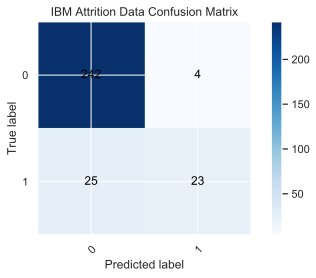

In [399]:
#Print Confusion Matrix
cm_gb = plot_confusion_matrix(y_val, y_pred, title='IBM Attrition Data Confusion Matrix');
print('Random Forest Classifcation Report: \n ', classification_report(y_val,y_pred));

Gradient Boosting Trees ROC AUC score =  0.8446815718157181


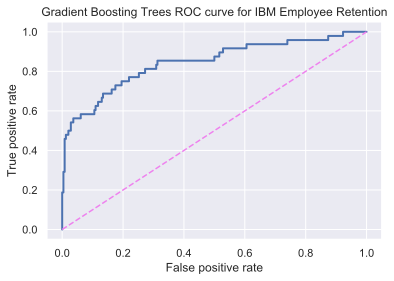

In [396]:
#Print ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, gs_gb.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Gradient Boosting Trees ROC curve for IBM Employee Retention');
print("Gradient Boosting Trees ROC AUC score = ", roc_auc_score(y_val, gs_gb.predict_proba(X_val)[:,1]))

# K-Nearest Neighbors

KNN is called a lazy learning algorithm because it doesn't learn or fit any parameter. It takes n_neighbors points from the training data closest to the point we're interested to predict it's class and take the mode (majority vote) of the classes for the neighboring point as its class. The two hyperparameters we're going to tune are:

- n_neighbors: number of neighbors to use in prediction.
- weights: how much weight to assign neighbors based on:
  
  "uniform": all neighboring points have the same weight.
  
  "distance": use the inverse of euclidean distance of each neighboring point used in prediction.

Let's fit KNN classifier and plot confusion matrix and ROC curve.



In [294]:
# Build KNN classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)

gs_knn = GridSearchCV(pip_knn,
                      param_grid={"kneighborsclassifier__n_neighbors": hyperparam_range,
                                  "kneighborsclassifier__weights": ["uniform", "distance"]},
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

gs_knn = gs_knn.fit(X_smoted, y_smoted)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in gs_knn.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_knn.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_knn.best_score_) * 100))

#Save Model
filename = './data/fit_models/KNN/KNN_model.sav'
pickle.dump(gs_knn, open(filename, 'wb'))

#Predict Y using Model
y_pred = gs_knn.predict(val_data_list[0])

filename = './data/fit_models/KNN/KNN_ypred.sav'
pickle.dump(y_pred, open(filename, 'wb'))

The best hyperparameters:
-------------------------
n_neighbors :  2
weights :  uniform
Best 10-folds CV f1-score: 90.84%.


Confusion matrix, without normalization
Classifcation Report: 
                precision    recall  f1-score   support

           0       0.86      0.85      0.86       246
           1       0.28      0.29      0.29        48

   micro avg       0.76      0.76      0.76       294
   macro avg       0.57      0.57      0.57       294
weighted avg       0.77      0.76      0.76       294



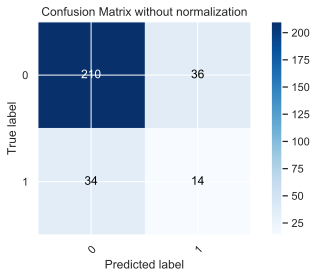

In [295]:
#Print Confusion Matrix
cm_knn = plot_confusion_matrix(y_val, y_pred, title='Confusion Matrix without normalization');
print('Classifcation Report: \n ', classification_report(y_val,y_pred));

KNN ROC AUC score =  0.6808943089430893


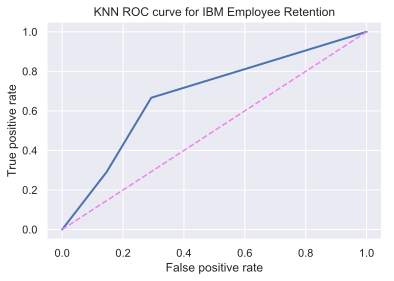

In [302]:
#Print ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, gs_knn.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for IBM Employee Retention');
print("KNN ROC AUC score = ", roc_auc_score(y_val, gs_knn.predict_proba(X_val)[:,1]))

# Logistic Regression

For logistic regression, we'll tune three hyperparameters:
- penalty: type of regularization, L2 or L1 regularization.
- C: the opposite of regularization of parameter λ. The higher C the less regularization. We'll use values that cover the full  range between unregularized to fully regularized where model is the mode of the examples' label.
- fit_intercept: whether to include intercept or not.

We won't use any non-linearities such as polynomial features.

In [306]:
# Build logistic model classifier
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight="balanced"))

hyperparam_range = np.arange(0.5, 20.1, 0.5)

hyperparam_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  hyperparam_range,
                   "logisticregression__fit_intercept": [True, False]
                  }

gs_logmodel = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring="accuracy",
                           cv=2,
                           n_jobs=-1)

gs_logmodel = gs_logmodel.fit(X_smoted, y_smoted)

print("\033[1m" + "\033[0m" + "The best hyperparameters:")
print("-" * 25)
for hyperparam in gs_logmodel.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_logmodel.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_logmodel.best_score_) * 100))

#Save Model
filename = './data/fit_models/logistic_regression/logistic_regression_model.sav'
pickle.dump(gs_logmodel, open(filename, 'wb'))

#Predict Y using Model
y_pred = gs_logmodel.predict(val_data_list[0])

filename = './data/fit_models/logistic_regression/logistic_regression_ypred.sav'
pickle.dump(y_pred, open(filename, 'wb'))

The best hyperparameters:
-------------------------
C :  0.5
fit_intercept :  True
penalty :  l2
Best 10-folds CV f1-score: 79.86%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix, without normalization
Classifcation Report: 
                precision    recall  f1-score   support

           0       0.95      0.79      0.86       246
           1       0.42      0.79      0.55        48

   micro avg       0.79      0.79      0.79       294
   macro avg       0.69      0.79      0.71       294
weighted avg       0.86      0.79      0.81       294



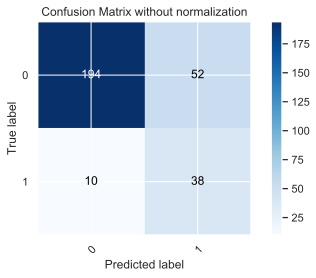

In [307]:
#Print Confusion Matrix
cm_logreg = plot_confusion_matrix(y_val, y_pred, title='Confusion Matrix without normalization');
print('Classifcation Report: \n ', classification_report(y_val,y_pred));

Logistic Regression ROC AUC score =  0.8541666666666666


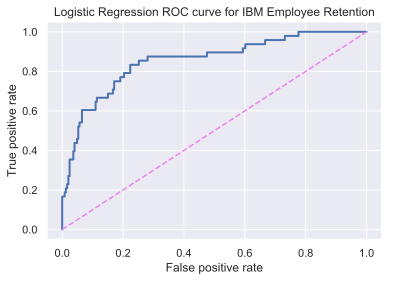

In [308]:
#Print ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, gs_logmodel.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve for IBM Employee Retention');
print("Logistic Regression ROC AUC score = ", roc_auc_score(y_val, gs_logmodel.predict_proba(X_val)[:,1]))

# Support Vector Machine (SVM)

SVM is comutationally very expensive to tune it's hyperparameters for two reasons:
- With big datasets, it becomes very slow.
- It has good number of hyperparameters to tune that takes very long time to tune on a CPU.

Therefore, we'll use recommended hyperparameters' values from the paper we mentioned before that showed to yield the best performane on Penn Machine Learning Benchmark 165 datasets. The hyperparameters that we usually look to tune are:

C, gamma, kernel, degree and coef0

In [311]:
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel="poly",
                            degree=5,
                            coef0=10,
                            probability=True))

clf_svc = clf_svc.fit(X_smoted, y_smoted)

svc_cv_scores = cross_val_score(clf_svc,
                                X=X_smoted,
                                y=y_smoted,
                                scoring="f1",
                                cv=10,
                                n_jobs=-1)

# Print CV
print("\033[1m" + "\033[94m" + "The 10-folds CV f1-score is: {:.2f}%".format(
       np.mean(svc_cv_scores) * 100))

#Save Model
filename = './data/fit_models/SVC/SVC_model.sav'
pickle.dump(clf_svc, open(filename, 'wb'))

#Predict Y using Model
y_pred = clf_svc.predict(val_data_list[0])

filename = './data/fit_models/SVC/SVC_pred.sav'
pickle.dump(y_pred, open(filename, 'wb'))

The 10-folds CV f1-score is: 93.38%


Confusion matrix, without normalization
Classifcation Report: 
                precision    recall  f1-score   support

           0       0.89      0.89      0.89       246
           1       0.45      0.46      0.45        48

   micro avg       0.82      0.82      0.82       294
   macro avg       0.67      0.67      0.67       294
weighted avg       0.82      0.82      0.82       294



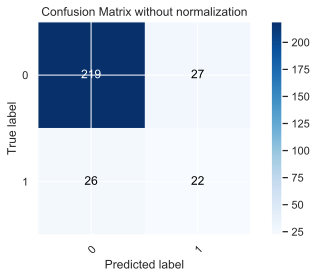

In [312]:
#Print Confusion Matrix
cm_svc = plot_confusion_matrix(y_val, y_pred, title='Confusion Matrix without normalization');
print('Classifcation Report: \n ', classification_report(y_val,y_pred));

SVC ROC AUC score =  0.8019563008130082


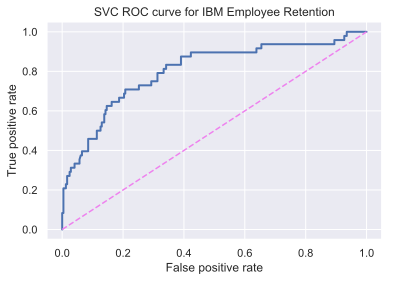

In [314]:
#Print ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, clf_svc.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SVC ROC curve for IBM Employee Retention');
print("SVC ROC AUC score = ", roc_auc_score(y_val, clf_svc.predict_proba(X_val)[:,1]))

In [322]:
with open("./data/fit_models/SMOTE.sav", 'rb') as file:
        clf_rf = pickle.load(file)

The accuracy rate and f1-score on test data are:
RF: 87.76%, 45.45%.
LR: 78.91%, 55.07%.
SVC: 81.97%, 45.36%.
GBT: 87.41%, 54.32%.
KNN: 76.19%, 28.57%.


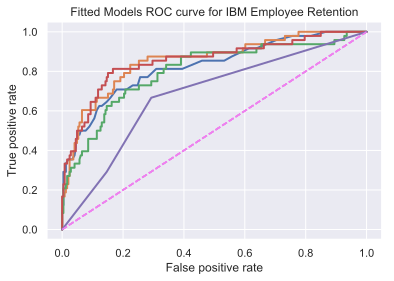

In [337]:
titles = ['RF','LR','SVC','GBT','KNN']
# fitted_models = [clf_rf, gs_logmodel, clf_svc, gs_gb, gs_knn]
estimators = {"RF": clf_rf,
              "LR": gs_logmodel,
              "SVC": clf_svc,
              "GBT": gs_gb,
              "KNN": gs_knn}

print("The accuracy rate and f1-score on test data are:")
for estimator in estimators.keys():
    print("{}: {:.2f}%, {:.2f}%.".format(estimator,
            accuracy_score(y_val, estimators[estimator].predict(X_val)) * 100,
            f1_score(y_val, estimators[estimator].predict(X_val)) * 100))
        
    fpr, tpr, thresholds = roc_curve(y_val, estimators[estimator].predict_proba(X_val)[:,1])
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Fitted Models ROC curve for IBM Employee Retention');
    plt.legend()
    
    plt.legend(loc='bottom right', frameon=False)

# Check Balance of Classes
- Look at proportion of classes to see if we're dealing with balanced or imbalanced data, since each one has its own set of tools to be used when fitting classifiers

# Get number of Yes/No Attritions

In [345]:
# Refit RF classifier
clf_rf = RandomForestClassifier(n_estimators=100,
                                criterion="gini",
                                max_features='log2',
                                min_samples_leaf=1,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=123)


clf_rf.fit(StandardScaler().fit_transform(X_smoted), y_smoted)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

In [343]:
#Import Dataframe
with open('./data/ibm_df.pickle', 'rb') as file:
        ibm_df = pickle.load(file)

In [348]:
ibm_df.shape

(1470, 41)

In [366]:
importances

array([0.02523533, 0.03284725, 0.03232737, 0.04160049, 0.01872044,
       0.04194577, 0.03983713, 0.03121659, 0.06946198, 0.02389284,
       0.00632286, 0.02417182, 0.09354896, 0.03964517, 0.02136188,
       0.02294305, 0.04725268, 0.02351156, 0.02100012, 0.03118253,
       0.01830428, 0.01458017, 0.02808281, 0.01714972, 0.03114234,
       0.00557652, 0.01953363, 0.00541274, 0.00904815, 0.01652791,
       0.00477956, 0.0181409 , 0.00146824, 0.00513618, 0.00063052,
       0.01040045, 0.00846559, 0.01127726, 0.03186397, 0.05445325])

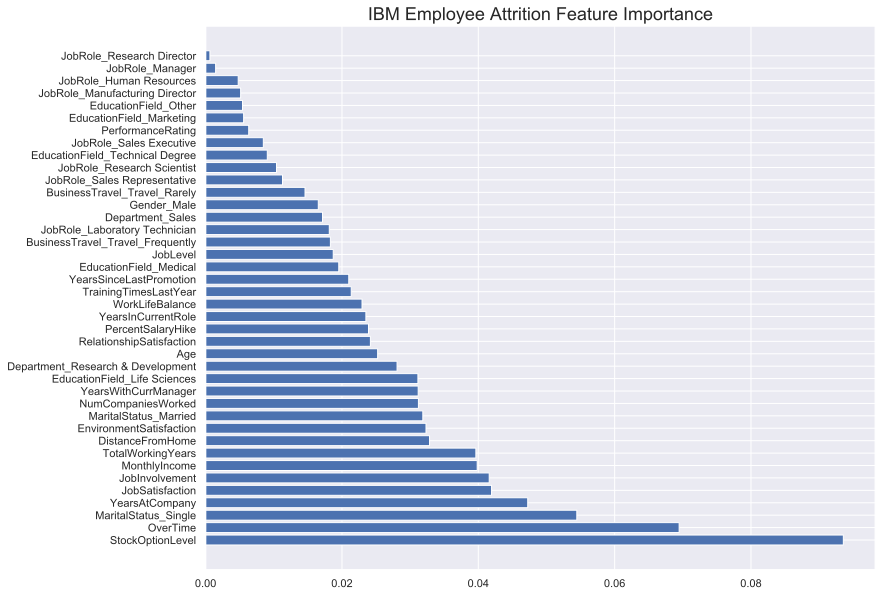

In [365]:
# Plot features importance
importances = clf_rf.feature_importances_
indices = np.argsort(clf_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 10))
plt.barh(range(1,41), importances[indices], align="center")
plt.yticks(range(1,41), ibm_df.columns[ibm_df.columns != "Attrition"][indices], rotation=0)
plt.xlabel('Genre', fontsize=5)
plt.title("IBM Employee Attrition Feature Importance", {"fontsize": 18});

In [355]:
df_columns = list(ibm_df.columns.values)

In [356]:
df_columns_list = [ ]
for idx, value in enumerate(df_columns):
    df_columns_list.append([value,idx])    

In [357]:
df_columns_list

[['Age', 0],
 ['Attrition', 1],
 ['DistanceFromHome', 2],
 ['EnvironmentSatisfaction', 3],
 ['JobInvolvement', 4],
 ['JobLevel', 5],
 ['JobSatisfaction', 6],
 ['MonthlyIncome', 7],
 ['NumCompaniesWorked', 8],
 ['OverTime', 9],
 ['PercentSalaryHike', 10],
 ['PerformanceRating', 11],
 ['RelationshipSatisfaction', 12],
 ['StockOptionLevel', 13],
 ['TotalWorkingYears', 14],
 ['TrainingTimesLastYear', 15],
 ['WorkLifeBalance', 16],
 ['YearsAtCompany', 17],
 ['YearsInCurrentRole', 18],
 ['YearsSinceLastPromotion', 19],
 ['YearsWithCurrManager', 20],
 ['BusinessTravel_Travel_Frequently', 21],
 ['BusinessTravel_Travel_Rarely', 22],
 ['Department_Research & Development', 23],
 ['Department_Sales', 24],
 ['EducationField_Life Sciences', 25],
 ['EducationField_Marketing', 26],
 ['EducationField_Medical', 27],
 ['EducationField_Other', 28],
 ['EducationField_Technical Degree', 29],
 ['Gender_Male', 30],
 ['JobRole_Human Resources', 31],
 ['JobRole_Laboratory Technician', 32],
 ['JobRole_Manager', 